2025-12-17 14:26:38.111650: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 14:26:38.404685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 14:26:40.196078: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 14:26:40.215168: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 14:26:45.371436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

✅ Data ready: Train=(81309, 10, 15), Test=(20328, 10, 15)
Epoch 1/5
636/636 [==============================] - 16s 18ms/step - loss: 0.0174 - accuracy: 0.9970 - val_loss: 0.5303 - val_accuracy: 0.7897
Epoch 2/5
636/636 [==============================] - 10s 16ms/step - loss: 6.9547e-06 - accuracy: 1.0000 - val_loss: 0.5274 - val_accuracy: 0.8007
Epoch 3/5
636/636 [==============================] - 11s 17ms/step - loss: 3.1592e-06 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.8203
Epoch 4/5
636/636 [==============================] - 10s 16ms/step - loss: 1.6691e-06 - accuracy: 1.0000 - val_loss: 0.5242 - val_accuracy: 0.8261
Epoch 5/5
636/636 [==============================] - 5s 6ms/step

✅ Clean accuracy (noise defense): 0.8327
636/636 [==============================] - 3s 5ms/step
🧠 Robust accuracy under attack: 0.8315
📉 Accuracy drop: 0.12%



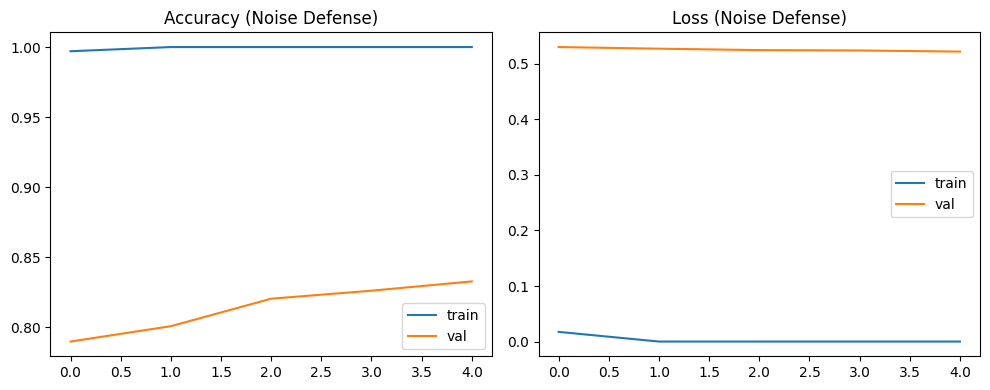

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# 1️⃣ Load and preprocess the PMU data
file_path = "data/Phasor Measurement Unit Data - Labeled/PMU_data.xlsx"
df = pd.read_excel(file_path).drop(columns=["Unnamed: 0"])
X = df.drop(columns=["Class Labels"]).values
y = df["Class Labels"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# create time-window sequences
window = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - window):
    X_seq.append(X_scaled[i : i + window])
    y_seq.append(y[i + window])
X_seq, y_seq = np.array(X_seq, np.float32), np.array(y_seq, np.int64)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
print(f"✅ Data ready: Train={X_train.shape}, Test={X_test.shape}")


# 2️⃣ Noise-injection function
def add_noise(data, noise_level=0.05):
    return data + noise_level * np.random.randn(*data.shape)


X_train_noisy = add_noise(X_train, noise_level=0.05)


# 3️⃣ LSTM model
model = Sequential(
    [
        tf.keras.Input(shape=(window, X_train.shape[2])),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


# 4️⃣ Train on noisy data
history = model.fit(
    X_train_noisy,
    y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128,
    verbose=1,
)


# 5️⃣ Evaluate on clean data
pred_clean = (model.predict(X_test) > 0.5).astype(int).ravel()
clean_acc = accuracy_score(y_test, pred_clean)
print(f"\n✅ Clean accuracy (noise defense): {clean_acc:.4f}")


# 6️⃣ Simple FGSM-like perturbation for robustness test
def fgsm_attack(x, epsilon=0.1):
    return x + epsilon * np.sign(np.random.randn(*x.shape))


X_test_adv = fgsm_attack(X_test, epsilon=0.1)
pred_adv = (model.predict(X_test_adv) > 0.5).astype(int).ravel()
adv_acc = accuracy_score(y_test, pred_adv)

print(f"🧠 Robust accuracy under attack: {adv_acc:.4f}")
print(f"📉 Accuracy drop: {(clean_acc - adv_acc) * 100:.2f}%\n")


# 7️⃣ Plot curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy (Noise Defense)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss (Noise Defense)")
plt.legend()
plt.tight_layout()
plt.savefig("noise_defense_plot.png")

